Import Modules

In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

#Import Modules for Neural Network
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score


Display Data and info of Data

In [50]:
#Load Data Set 1
df_1 = pd.read_csv("Data/005930.KS_weekly.csv")

#Display df1
df_1.head()

Date     Open     High      Low    Close     Adj Close      Volume
0  2018-12-31  38700.0  39400.0  36850.0  38750.0  33061.843750  47177112.0
1  2019-01-07  38000.0  40700.0  37950.0  40050.0  34171.023438  68587020.0
2  2019-01-14  40050.0  42750.0  39850.0  42750.0  36474.683594  54106211.0
3  2019-01-21  42750.0  45500.0  41350.0  45050.0  38437.058594  76571367.0
4  2019-01-28  45050.0  47050.0  44350.0  46350.0  39546.238281  69174596.0

In [51]:
#Load Data Set 1
df_2 = pd.read_csv("Data/005930.KS_weekly.csv")

#Display df1
df_2.head()

Date     Open     High      Low    Close     Adj Close      Volume
0  2018-12-31  38700.0  39400.0  36850.0  38750.0  33061.843750  47177112.0
1  2019-01-07  38000.0  40700.0  37950.0  40050.0  34171.023438  68587020.0
2  2019-01-14  40050.0  42750.0  39850.0  42750.0  36474.683594  54106211.0
3  2019-01-21  42750.0  45500.0  41350.0  45050.0  38437.058594  76571367.0
4  2019-01-28  45050.0  47050.0  44350.0  46350.0  39546.238281  69174596.0

In [52]:
#Load Data Set 1
df_3 = pd.read_csv("Data/005930.KS_monthly.csv")

#Display df1
df_3.head()

Date     Open     High      Low    Close     Adj Close     Volume
0  2018-12-31  38700.0  47050.0  36850.0  46150.0  39375.601562  301783852
1  2019-01-31  46650.0  47550.0  44250.0  45100.0  38479.726562  194923203
2  2019-02-28  45100.0  47000.0  43100.0  44650.0  38095.785156  223260605
3  2019-03-31  45200.0  47600.0  43800.0  45850.0  39427.402344  209113436
4  2019-04-30  45850.0  46150.0  40850.0  42500.0  36546.667969  271585071

Display Data in graph per day

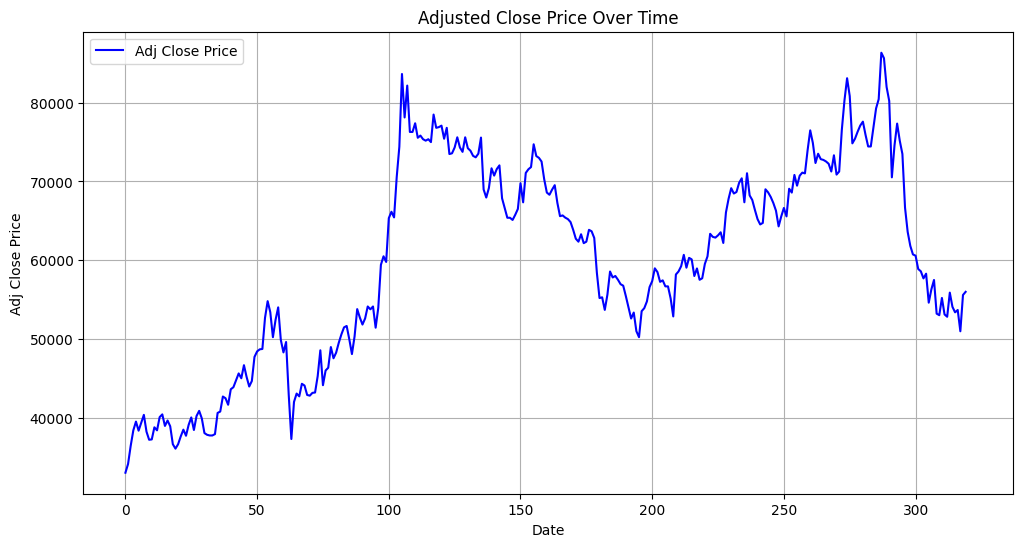

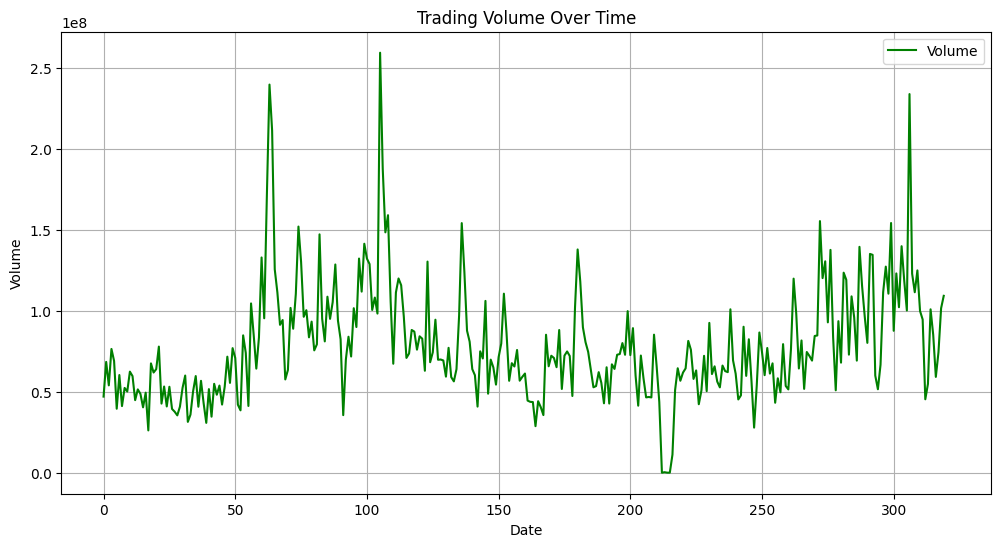

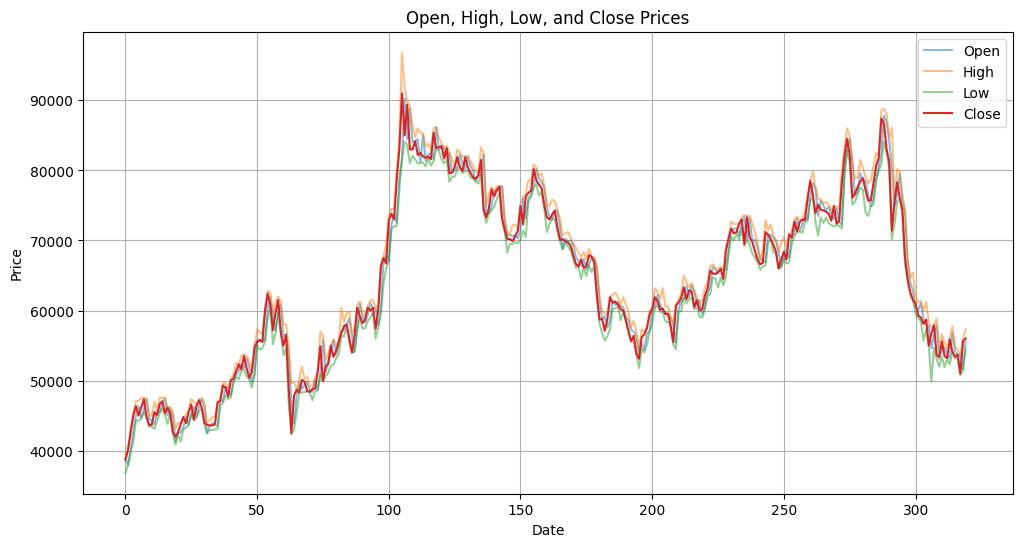

In [53]:

# 3. Plotting the Price Data (using Adj Close as the primary example)
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.plot(df_1['Adj Close'], label='Adj Close Price', color='blue')
plt.title('Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.grid(True)
plt.legend()
plt.show()

# 4. Plotting Volume
plt.figure(figsize=(12, 6))
plt.plot(df_1['Volume'], label='Volume', color='green')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()
plt.show()

# 5.  Plotting Multiple Price Components (Optional - for comparison)
plt.figure(figsize=(12, 6))
plt.plot(df_1['Open'], label='Open', alpha=0.5)
plt.plot(df_1['High'], label='High', alpha=0.5)
plt.plot(df_1['Low'], label='Low', alpha=0.5)
plt.plot(df_1['Close'], label='Close', alpha=1)  # Emphasize Close
plt.title('Open, High, Low, and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()


Process Data

In [54]:
#Select Features and Target
features = ['Open', 'High', 'Low', 'Volume']
target = 'Adj Close'

#Copy Df_1
df_1_copy = df_1[features + [target]].copy()

#Scale the Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_1_copy)

#Separate features and target
X = scaled_data[:, :-1]
y = scaled_data[:, -1]

Prepare Secuences for RNN

In [55]:
#Set Number of Days to use for prediction
seq_length = 50
xs = []
ys = []
for i in range(len(X) - seq_length):
    xs.append(X[i:(i + seq_length)])
    ys.append(y[i + seq_length])
X = np.array(xs)
y = np.array(ys)

Slit the Data for Training

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

Define the Neural Network

In [57]:
#Define My Model
class StockPriceRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(StockPriceRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [58]:
#Define vars
hidden_size = 128
num_layers = 3
output_size = 1

#Create a new model
model = StockPriceRNN(
    input_size=X_train.shape[2], 
    hidden_size=hidden_size, 
    output_size=output_size, 
    num_layers=num_layers
)

Train the Model

In [59]:
epochs = 200
batch_size = 34
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/200], Loss: 0.1105
Epoch [2/200], Loss: 0.0513
Epoch [3/200], Loss: 0.0348
Epoch [4/200], Loss: 0.0724
Epoch [5/200], Loss: 0.0281
Epoch [6/200], Loss: 0.0261
Epoch [7/200], Loss: 0.0166
Epoch [8/200], Loss: 0.0113
Epoch [9/200], Loss: 0.0073
Epoch [10/200], Loss: 0.0034
Epoch [11/200], Loss: 0.0044
Epoch [12/200], Loss: 0.0071
Epoch [13/200], Loss: 0.0032
Epoch [14/200], Loss: 0.0117
Epoch [15/200], Loss: 0.0028
Epoch [16/200], Loss: 0.0019
Epoch [17/200], Loss: 0.0028
Epoch [18/200], Loss: 0.0031
Epoch [19/200], Loss: 0.0060
Epoch [20/200], Loss: 0.0028
Epoch [21/200], Loss: 0.0022
Epoch [22/200], Loss: 0.0024
Epoch [23/200], Loss: 0.0010
Epoch [24/200], Loss: 0.0043
Epoch [25/200], Loss: 0.0021
Epoch [26/200], Loss: 0.0060
Epoch [27/200], Loss: 0.0051
Epoch [28/200], Loss: 0.0031
Epoch [29/200], Loss: 0.0024
Epoch [30/200], Loss: 0.0037
Epoch [31/200], Loss: 0.0020
Epoch [32/200], Loss: 0.0076
Epoch [33/200], Loss: 0.0027
Epoch [34/200], Loss: 0.0013
Epoch [35/200], Loss: 0

Evaluate the Model

In [60]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    predictions = model(X_test_tensor)
    mse = nn.MSELoss()(predictions.squeeze(), y_test_tensor)
    print(f'Test MSE: {mse:.4f}')

    # Calculate Accuracy (example - you might need to adjust based on your definition)
    # This is a simplified example and might not be directly applicable to all regression problems.
    # Accuracy in regression is often defined as "how close" the predictions are to the actual values within a certain tolerance.

    tolerance = 0.05  # Define how much deviation is acceptable (e.g., 5%)
    correct_predictions = torch.sum(torch.abs(predictions.squeeze() - y_test_tensor) <= tolerance)
    total_predictions = y_test_tensor.size(0)
    accuracy = (correct_predictions.float() / total_predictions) * 100
    print(f'Test Accuracy (within {tolerance*100}% tolerance): {accuracy:.2f}%')

Test MSE: nan
Test Accuracy (within 5.0% tolerance): 47.27%
